# Load libraries

In [229]:
import pandas as pd
import numpy as np
from scipy.stats import beta, bernoulli
import plotly.graph_objs as go
import statsmodels.stats.api as sms
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import copy

# Создадим класс банера

In [230]:
class banner_class():

    '''
    Тут мы инициализируем основные параметры, которые отвечают
    за форму нормального распределения, все это будет описывать
    с какой вероятностью у нас произойдет конверсия от этого банера
    '''
    def __init__(self,Id,mean,sigma):
        global plt
        global bernoulli,norm
        import matplotlib.pyplot as plt
        from scipy.stats import norm,bernoulli
        

        self.mean = mean
        self.sigma = sigma
        self.stat = {'id': Id,'a':0,'b':0,'conv':0,'cost':0}
        self.a = 0
        self.b = 0

    # Визуализируем наше распределение вероятностей
    def plot_prob(self):
        count, bins, ignored = plt.hist(np.random.normal(self.mean, self.sigma,1000),
                                        30,
                                        density=True)

        plt.plot(bins, 1/(self.sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - self.mean)**2 / (2 * self.sigma**2) ),linewidth=2,color='r')
        plt.show()

    # Собираем статистику о работе банера
    def get_stat(self,value):
        self.stat['a'] += 1
        self.stat['cost'] += 100
        if value == 1:
            self.stat['b'] +=1
        self.stat['conv'] = self.stat['b']/self.stat['a']

    # Возвращаем конверсию с заданной вероятностью
    def conversion(self):
        prob = norm.rvs(self.mean,self.sigma)
        if prob < 0:
            prob = 0
        elif prob > 1:
            prob = 1
        result = bernoulli.rvs(prob)
        self.get_stat(result)

In [231]:
banner_1 = banner_class('1',0.9,1)

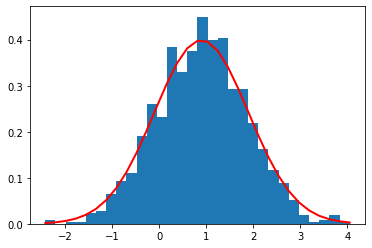

In [232]:
banner_1.plot_prob()

# Создадим класс генератора банеров

In [233]:
class banners_generator():

    def __init__(self):
        global random
        import random

    def generate(self,n):
        banners = [banner_class(i,random.uniform(0.035, 0.06),0.01) for i in range(n)]
        return banners

# Создадим класс семплирования Томпсона

In [234]:
class tompson_sampling():    


    # Инициалицируем количество банеров
    def __init__(self,data):
        self.length = len(data)
        self.data = data
        self.win_index = None
        self.win_list = []


    def do_sample(self):

        # Проверяем первая ли эта итерация или нет
        if self.win_index == None:
            # Рандомно выберем первого игрока
            self.win_index = np.random.randint(0,self.length,1)[0]
        else:
            pass
        
        self.win_list.append(self.win_index)
        # Сделаем показ
        self.data[self.win_index].conversion()
        # Уточним распределения и выведем победителя
        self.conv_list = []
        for i in range(self.length):
            conv = random.betavariate(1 + self.data[i].stat['b'],
                        1 + self.data[i].stat['a'] - self.data[i].stat['b'])     
            self.conv_list.append(conv)
        self.win_index = np.argmax(self.conv_list)


    # Создадим функцию для просмотра показателей
    def print_data(self):
        result = [self.data[i].stat for i in range(self.length)]
        return pd.DataFrame(result)


    # Тут мы создаем цвет для дальнейшей визуализации
    def create_color(self):
        colors = []
        for i in range(self.length):
            r1 = np.random.randint(0,255)
            r2 = np.random.randint(0,255)
            r3 = np.random.randint(0,255)   
            color = f'rgba({r1},{r2},{r3},.3)'
            colors.append(color)
        return colors


    # Эта функция необходима для получения характеристик распределения
    # Она будет использоваться как в визуализации, так и в тестировании
    def get_distrib(self,l=0, r=1,z = 0.0001):
        x = np.arange(l,r,z)
        y_list = []
        self.quantiles = []
        for i in range(self.length):

            Id = self.data[i].stat['id']
            y = beta.pdf(x,1 + self.data[i].stat['b'],
                            1 + self.data[i].stat['a'] - self.data[i].stat['b'])

            q1 = beta(1 + self.data[i].stat['b'],
                    1 + self.data[i].stat['a'] - self.data[i].stat['b']).ppf(0.025)
                
            q2 = beta(1 + self.data[i].stat['b'],
                    1 + self.data[i].stat['a'] - self.data[i].stat['b']).ppf(0.975)
                    
            median = beta(1 + self.data[i].stat['b'],
                    1 + self.data[i].stat['a'] - self.data[i].stat['b']).ppf(0.5)

            self.quantiles.append({'id':Id,'q1':q1,'q2':q2,'median':median})
            y_list.append(y)
        return y_list


    # Функция контроля достижения статистической значимости
    # если 0.975 квантиль второго распределения стал меньше 0.025 квантиля
    # первого распределения, то тестирование завершено
    def quantiles_control(self):
        self.quantiles = pd.DataFrame(self.quantiles)

        # Отсортируем средние дабы найти первого и второго
        median_list = self.quantiles['median'].sort_values(ascending = False)

        # Выберем id победителей
        first = self.quantiles.loc[self.quantiles['median'] == median_list.iloc[0]]
        second = self.quantiles.loc[self.quantiles['median'] == median_list.iloc[1]]

        if first['q1'].values[0] > second['q2'].values[0]:
            return False
        else:
            return True
    

    def get_result(self):
        sort_data = sorted(self.data, key=lambda d: d.stat['conv'],reverse=True)
        sort_data  = pd.DataFrame([sort_data[i].stat for i in range(len(sort_data))])
        result = {'winner':sort_data.iloc[0]['id'],'money cost for test': sort_data['cost'].sum()}
        print(result)
        return pd.DataFrame([i.stat for i in self.data])


    def start_test(self,n=20000,fast = True):
        self.do_sample()
        l = 0.03
        r = 0.07
        z = 0.0001
        self.get_distrib()
        stage = 0
        if fast == True:
            for i in range(n):
                self.do_sample()
        else:
            while self.quantiles_control():
                stage += 1
                self.do_sample()
                if stage % 5000 == 0:
                     self.get_distrib()
                if stage > n:
                    print(f'Статистическая значимость не достигнута после {n} итераций')
                    break
        # Визуализация
        y_list = self.get_distrib(l,r,z)
        colors = self.create_color()
        x = np.arange(l,r,z)
        fig = go.Figure(data=[go.Scatter(x = x,
                        y = y_list[a],
                        marker = dict(color=(colors[a])),
                        fillcolor = colors[a],
                        fill='tozeroy') for a in range(self.length)])
        fig.update_layout(
        title="Распределение конверсии",
        xaxis_title="Значение конверсии",
        yaxis_title="Плотность вероятности")
        fig.show()


    def start_test_gif(self):
# Назначим исходные переменные и получим данные о начальном распределении
        self.do_sample()
        y_list = self.get_distrib()
        colors = self.create_color()
        x = np.arange(0,1,0.01)
        frames = []
        slider_steps = []

# Нарисуем исходные изображения
        fig = go.Figure(data=[go.Scatter(x = x,
                        y = y_list[a],
                        marker = dict(color=(colors[a])),
                        fillcolor = colors[a],
                        fill='tozeroy') for a in range(self.length)])

        stage = 0
        while self.quantiles_control():
            stage += 1
            self.do_sample()
            y_list = self.get_distrib()
            if stage % 100 == 0 :
                print(f'Cтатистическая значимость на {stage} итерации не достигнута')
            if stage > 601:
                print('Статистическая значимость не достигнута после 600 итераций')
                break

            frame_1 = [go.Scatter(x = x,
                        y = y_list[a],
                        marker = dict(color=(colors[a])),
                        fillcolor = colors[a],
                        fill='tozeroy') for a in range(self.length)]

            layout = go.Layout(title=f'Beta Distributions on {stage}',
                       xaxis={'title': 'Possible conversion values'},
                       yaxis={'title': 'Probability Density'})

            frame = go.Frame(data = frame_1, name = stage,layout=layout)
            frames.append(frame)

            # Для каждой стадии создадим соответствующий шаг слайдера
            slider_step = dict(method = 'animate',
                            label = stage,
                            value = stage,
                            args = [
                                [stage],
                                dict(frame = dict(duration = 600, redraw = True),
                                        mode = 'immediate',
                                        transition = dict(duration = 0))])

            # Добавляем шаг в список шагов
            slider_steps.append(slider_step)
        # Присваиваем кадрам фигуры, полученные выше кадры
        fig.frames = frames
        # Создадим кнопки запуска и останавки анимации
        fig.layout['updatemenus'] = [
                dict(
                    type="buttons",
                    buttons=[
                        dict(
                            label="▶",
                            method="animate",
                            args=[
                                None,
                                dict(
                                    frame=dict(duration=1, redraw=True),
                                    fromcurrent=True,
                                    transition=dict(
                                        duration=0, easing='quadratic-in-out')
                                )
                            ]
                        ),
                        dict(
                            label="❚❚",
                            method="animate",
                            args=[
                                [None],
                                dict(
                                    frame=dict(duration=0, redraw=True),
                                    mode='immediate',
                                    transition=dict(duration=0)
                                )
                            ]
                        )
                    ],
                    direction='left',
                    pad={'r': 10, 't': 87},
                    showactive=False,
                    x=0,
                    xanchor='right',
                    y=0.1,
                    yanchor='top'
                )
            ]
        # Создадим слайдер. Присвоим шаги
        fig.layout['sliders'] = [dict(
            active=0,
            yanchor='top',
            xanchor='left',
            currentvalue=dict(
                font=dict(size=14),
                prefix='',
                visible=True,
                xanchor='center'
            ),
            transition=dict(duration=0, easing='cubic-in-out'),
            pad=dict(b=10, t=50),
            len=1,
            x=0,
            y=0,
            steps=slider_steps
        )]
        fig.show()

# A/B test

In [235]:
class ab_test_model():


    def __init__(self,data,baseline,min_eff):
        self.data = data
        self.baseline = baseline
        self.min_eff = min_eff


    def calculate_sample(self):
        effect_size = sms.proportion_effectsize(self.baseline,self.baseline + self.min_eff)
        required_n = sms.NormalIndPower().solve_power(effect_size,
                                                      power=0.8,
                                                      alpha=0.05,
                                                      ratio=1)
        required_n = ceil(required_n)
        return required_n


    def collect_data(self):
        n = self.calculate_sample()
        print(f'Необходимо иметь по {n} наблюдений')
        for d in range(len(self.data)):
            for i in range(n):
                self.data[d].conversion()


    def test(self,alpha):
        self.test_data = []
        for i in range(len(self.data)):
            for j in range(len(self.data)):
                if j != i:

                    successes = [self.data[i].stat['b'], self.data[j].stat['b']]
                    nobs = [self.data[i].stat['a'], self.data[j].stat['a']]

                    var1 = self.data[i].stat['id']
                    var2 = self.data[j].stat['id']

                    z_stat, pval = proportions_ztest(successes,nobs,alpha)
                    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

                    row = {'var1':var1, 'var2':var2, 'pval':pval}
                    self.test_data.append(row)
                    # print(f'Сравнение варианта {var1} и варианта {var2}')
                    # print(f'z statistic: {z_stat:.2f}')
                    # print(f'p-value: {pval:.3f}')
                    # print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
                    # print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')
                    # print('\n')
                else:
                    pass
                
    

    def get_result(self):
        sort_data = sorted(self.data, key=lambda d: d.stat['conv'],reverse=True)
        sort_data  = pd.DataFrame([sort_data[i].stat for i in range(len(sort_data))])
        result = {'winner':sort_data.iloc[0]['id'],'money cost for test': sort_data['cost'].sum()}
        print(result)
        return pd.DataFrame([i.stat for i in self.data])

# Симуляция

## Create data

In [236]:
data1 = banners_generator().generate(5)
data2 = copy.deepcopy(data1)

## Тестирование MAB

In [237]:
ts = tompson_sampling(data1)
ts.start_test(n = 30000,fast=True)

In [238]:
result1 = ts.get_result()

{'winner': 1.0, 'money cost for test': 3000100}


## Тестирование классическим А/В тестом

In [239]:
ab = ab_test_model(data2,0.05,0.005)
ab.collect_data()

Необходимо иметь по 31218 наблюдений


In [240]:
ab.test(0.05)

In [241]:
result2 = ab.get_result()

{'winner': 1.0, 'money cost for test': 15609000}


# Сравнение и подведение итогов

In [242]:
def compare(data1,data2):
    conv1 = data1['b'].sum()/data1['a'].sum()
    conv2 = data2['b'].sum()/data2['a'].sum()

    cost1 = data1['cost'].sum()
    cost2 = data2['cost'].sum()

    print(f'Средняя конверсия MAB = {conv1*100}%, A/B теста = {conv2*100}%')
    print(f'Разница в конверсии {(conv1-conv2)*100}')

    print(f'Потрачено MAB = {cost1}, A/B теста = {cost2}')
    print(f'Разница в тратах в % {cost2 / cost1 * 100}')

    display(data1)
    display(data2)

In [243]:
compare(result1,result2)

Средняя конверсия MAB = 5.813139562014599%, A/B теста = 4.995195079761676%
Разница в конверсии 0.8179444822529234
Потрачено MAB = 3000100, A/B теста = 15609000
Разница в тратах в % 520.2826572447585


,id,a,b,conv,cost
0,0,2663,143,0.053699,266300
1,1,18254,1099,0.060206,1825400
2,2,245,5,0.020408,24500
3,3,928,39,0.042026,92800
4,4,7911,458,0.057894,791100


,id,a,b,conv,cost
0,0,31218,1440,0.046127,3121800
1,1,31218,1857,0.059485,3121800
2,2,31218,1271,0.040714,3121800
3,3,31218,1407,0.045070,3121800
4,4,31218,1822,0.058364,3121800
